**Author:** Sydney Crandall

**Last Edited:** June 1st, 2022

## Initial work with Albuquerque dataset
- munged the raw dataset into daily and hourly datasets (see munge.py or Munging.ipynb for more details)
- clustered hourly noon data for 4 clusters and implemented the seasonal by year and scatterplot visualizations
- clustered daily data for 4 clusters and implemented the seasonal by year and scatterplot visualizations
- initialized centroids for the noon hourly cluster using kmeans++ method from [here](https://www.kdnuggets.com/2020/06/centroid-initialization-k-means-clustering.html), which maximizes the distance between the centroids before clustering

In [3]:
# imports
import pandas as pd
import numpy as np
import cluster
import math
import munge
import datetime as dt
from metpy.units import units
import visualizations as vis
from scipy.stats import iqr
import matplotlib.pyplot as plt
import seaborn as sb

### Munge the Albuquerque raw LCD dataset

In [4]:
# read in the Albuquerque raw LCD dataset
alb = munge.from_raw("AlbuquerqueRaw.csv")

In [5]:
alb = munge.add_season_rearrange(alb)

In [6]:
alb = munge.replace_month_hour(alb)

In [7]:
alb = munge.wet_bulb(alb)

In [8]:
albHourlyMunged = munge.to_hourly(alb)

In [9]:
albDailyMunged = munge.to_daily(albHourlyMunged)

In [10]:
# save daily and hourly datasets
albDailyMunged.to_csv("albDaily.csv")
albHourlyMunged.to_csv("albHourly.csv")

### Cluster the Albuquerque Hourly dataset at noon

In [9]:
included_cols = ['drytemp_F','dewtemp_F','wetbulb_F','RH','pres_mbar','wdir','wspd_mph','wgust_mph','prec_inch']
albSelect = cluster.select_time(albHourlyMunged,15)
albData, albScaledData = cluster.scale_and_convert_to_numpy(albSelect, included_cols)
albSelect.to_csv("albNoon.csv")

In [10]:
#init_centroids = cluster.plus_plus(albScaledData, 4)
init_centroids = 3
albCentroids, albIdx = cluster.cluster_data(init_centroids, albScaledData)

#### Seasonal Cluster assignment by year plot

In [15]:
cluster_label_list = ["cluster 1", "cluster 2", "cluster 3", "cluster 4"]

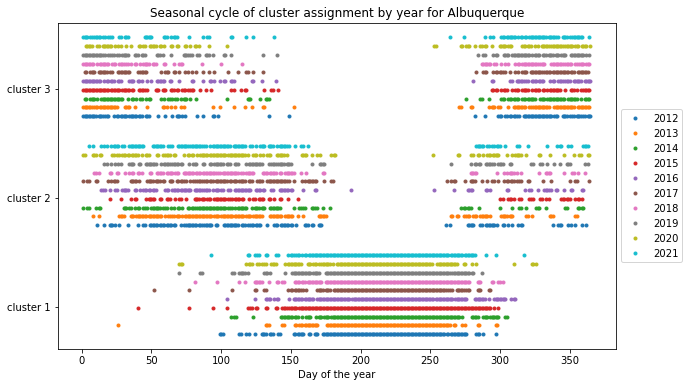

In [12]:
vis.seasonal_assignment_by_year("Albuquerque", cluster_label_list[0:3], 3, albSelect, albIdx)

In [13]:
centroidsScaledDF = pd.DataFrame(albCentroids, columns = included_cols)
centroidsDF = pd.DataFrame(albData, columns = included_cols).describe().loc["std"]*centroidsScaledDF
centroidsDF

,drytemp_F,dewtemp_F,wetbulb_F,RH,pres_mbar,wdir,wspd_mph,wgust_mph,prec_inch
0,84.533750,40.150864,59.279503,24.111130,838.160626,184.706103,9.674318,27.368684,0.002269
1,66.678595,17.054164,44.654666,17.986085,833.297061,254.094301,15.783633,29.325272,0.000070
2,52.346287,19.614169,38.700914,32.350439,839.767047,135.686337,5.799805,29.786196,0.000718


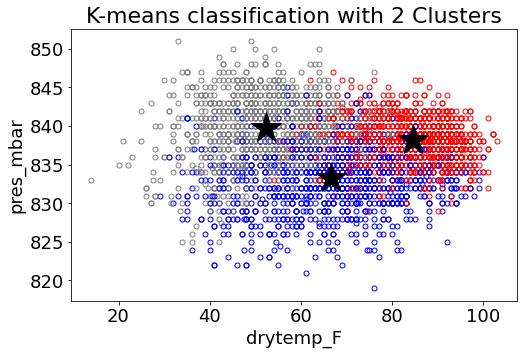

In [14]:
vis.variable_scatter_plots("drytemp_F", "pres_mbar", included_cols, 2, albIdx, albData, centroidsDF.to_numpy())

### Cluster the Albuquerque daily dataset

In [15]:
albDailyMunged

,datetime,tilt_season,drytemp_max,drytemp_min,dewtemp_avg,wetbulb_avg,RH_max,RH_min,pres_max,pres_min,wspd_max,wspd_min,wdir_avg,prec_inch,drytemp_max_hour,drytemp_min_hour,prec_max_hour,pres_max_hour,pres_min_hour,pres_tend
0,2012-01-01,1.0,51.0,28.0,16.0,30.0,60.0,21.0,852.0,846.0,9.0,0.0,154.0,0.00,13,6,0,9,23,-6.0
1,2012-01-02,1.0,49.0,29.0,17.0,29.0,64.0,23.0,855.0,850.0,10.0,0.0,130.0,0.00,15,4,0,8,22,-5.0
2,2012-01-03,1.0,50.0,26.0,20.0,30.0,75.0,28.0,850.0,843.0,7.0,0.0,107.0,0.00,15,1,0,0,23,-7.0
3,2012-01-04,1.0,52.0,35.0,21.0,33.0,59.0,27.0,852.0,846.0,13.0,0.0,96.0,0.00,13,6,0,9,0,6.0
4,2012-01-05,1.0,53.0,28.0,18.0,31.0,72.0,22.0,848.0,839.0,10.0,0.0,94.0,0.00,14,6,0,0,22,-9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2021-12-27,1.0,48.0,31.0,17.0,32.0,54.0,22.0,835.0,827.0,17.0,0.0,149.0,0.00,13,3,0,7,18,-8.0
3649,2021-12-28,1.0,48.0,37.0,21.0,33.0,59.0,29.0,830.0,826.0,18.0,5.0,244.0,0.00,13,1,0,9,3,4.0
3650,2021-12-29,1.0,46.5,30.5,25.0,33.0,96.0,41.5,835.0,827.0,22.0,0.0,233.0,0.01,14,7,5,22,0,8.0
3651,2021-12-30,1.0,46.0,33.0,23.0,33.0,70.0,37.0,836.0,832.0,14.0,0.0,183.0,0.00,15,6,0,8,15,-4.0


In [17]:
daily_cols = ["drytemp_max",'drytemp_min', 'dewtemp_avg','wetbulb_avg', 'RH_max','RH_min',
              'wspd_max', 'wdir_avg', 'prec_inch', 'drytemp_max_hour', 'drytemp_min_hour', 'pres_tend']

In [18]:
albDayData, albScaledDayData = cluster.scale_and_convert_to_numpy(albDailyMunged, daily_cols)

In [19]:
albDayCentroids, albDayIdx = cluster.cluster_data(4, albScaledDayData)


#### Seasonal cluster assignment by year plot

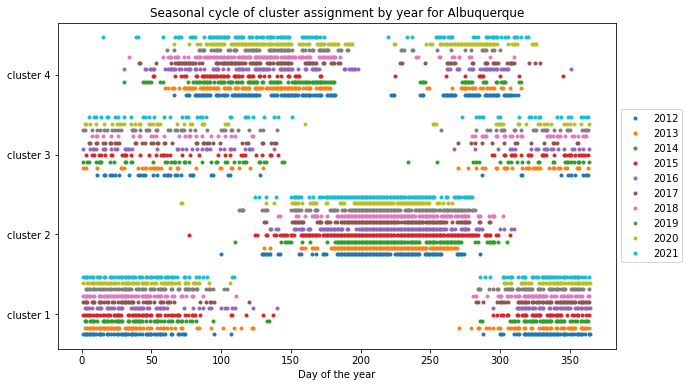

In [20]:
vis.seasonal_assignment_by_year("Albuquerque", cluster_label_list[0:4], 4, albDailyMunged, albDayIdx)

In [22]:
# convert the centroids from their scaled form back to a readable form
albCentroids = cluster.get_centroids(albDayCentroids, daily_cols, albDayData)
albCentroids

,drytemp_max,drytemp_min,dewtemp_avg,wetbulb_avg,RH_max,RH_min,wspd_max,wdir_avg,prec_inch,drytemp_max_hour,drytemp_min_hour,pres_tend
cluster,,,,,,,,,,,,
1,54.574524,30.737048,18.913888,33.033033,64.367311,24.960650,12.161644,149.021454,0.001817,14.743306,4.807416,-3.203184
2,85.934443,64.098746,48.111553,58.861853,66.714380,23.422138,19.339105,158.097555,0.025941,14.231564,5.624013,-3.025719
3,52.900509,35.685509,23.939237,35.691257,72.941019,31.124950,22.739566,205.530597,0.026744,12.022992,11.467908,4.818394
4,79.575941,52.824707,23.197350,46.337411,38.791232,10.652915,18.641387,177.407779,0.000083,14.705896,4.448182,-3.566508


### Create a dataframe of statistics from noon clustering

In [24]:
albDailyMunged["cluster"] = albDayIdx

In [25]:
# statistics of cluster1
clusterGroups = albDailyMunged.groupby("cluster")
cluster1 = clusterGroups.get_group(1).reset_index(drop = True)
cluster1Stats = cluster1.describe()
cluster1Stats

,tilt_season,drytemp_max,drytemp_min,dewtemp_avg,wetbulb_avg,RH_max,RH_min,pres_max,pres_min,wspd_max,wspd_min,wdir_avg,prec_inch,drytemp_max_hour,drytemp_min_hour,prec_max_hour,pres_max_hour,pres_min_hour,pres_tend,cluster
count,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.0
mean,1.857287,54.484818,30.871964,19.245951,33.159920,65.096657,25.402328,842.768188,837.602234,12.419535,0.295040,150.945343,0.002596,14.706478,4.770243,0.664980,6.752024,12.577935,-3.028340,1.0
std,1.245408,8.902333,7.059674,8.640593,5.974174,15.745201,12.031739,4.345104,4.892794,5.230009,1.063456,42.330284,0.015709,1.058032,2.178193,3.329903,5.907446,6.936461,4.590328,0.0
min,1.000000,25.000000,9.000000,-7.000000,13.000000,20.000000,5.000000,828.500000,821.000000,5.000000,0.000000,49.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,-14.000000,1.0
25%,1.000000,48.500000,26.000000,13.750000,29.000000,54.000000,17.000000,840.000000,834.000000,9.000000,0.000000,120.000000,0.000000,14.000000,4.000000,0.000000,0.000000,13.000000,-6.000000,1.0
50%,1.000000,55.000000,31.000000,19.000000,33.000000,64.000000,22.500000,843.000000,838.000000,11.000000,0.000000,149.000000,0.000000,15.000000,5.000000,0.000000,7.000000,15.000000,-4.000000,1.0
75%,2.000000,61.000000,36.000000,25.000000,37.000000,76.000000,30.000000,846.000000,841.000000,15.000000,0.000000,180.000000,0.000000,15.000000,6.000000,0.000000,9.000000,16.000000,-3.000000,1.0
max,4.000000,74.000000,48.000000,42.000000,48.000000,100.000000,78.000000,855.000000,850.000000,34.000000,10.000000,308.000000,0.215000,23.000000,23.000000,23.000000,23.000000,23.000000,11.000000,1.0


In [26]:
# statistics of cluster2
cluster2 = clusterGroups.get_group(2).reset_index(drop = True)
cluster2Stats = cluster2.describe()
cluster2Stats

,tilt_season,drytemp_max,drytemp_min,dewtemp_avg,wetbulb_avg,RH_max,RH_min,pres_max,pres_min,wspd_max,wspd_min,wdir_avg,prec_inch,drytemp_max_hour,drytemp_min_hour,prec_max_hour,pres_max_hour,pres_min_hour,pres_tend,cluster
count,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.0
mean,3.219306,85.974693,64.114342,48.074039,58.858482,66.590439,23.322399,842.338806,837.727722,19.370665,0.755858,158.067474,0.025670,14.242737,5.601687,3.646673,7.757263,13.535145,-3.009372,2.0
std,0.536372,7.520537,6.277252,6.028168,4.023810,15.018606,9.847296,2.576552,2.705299,6.533370,1.661741,30.035158,0.089171,1.316703,5.466229,7.150211,5.526173,4.910019,3.636893,0.0
min,2.000000,59.000000,43.000000,32.000000,45.000000,30.000000,5.000000,832.500000,828.000000,7.000000,0.000000,71.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,2.0
25%,3.000000,82.000000,61.000000,43.000000,57.000000,55.000000,16.000000,841.000000,836.000000,15.000000,0.000000,138.000000,0.000000,13.000000,3.000000,0.000000,6.000000,15.000000,-5.000000,2.0
50%,3.000000,88.000000,65.500000,48.000000,60.000000,67.000000,21.500000,842.000000,838.000000,18.500000,0.000000,158.000000,0.000000,15.000000,4.000000,0.000000,7.000000,15.000000,-4.000000,2.0
75%,4.000000,91.000000,68.500000,53.000000,62.000000,78.000000,29.000000,844.000000,839.000000,23.000000,0.000000,177.000000,0.002500,15.000000,5.000000,0.000000,8.000000,16.000000,-3.000000,2.0
max,4.000000,102.000000,76.000000,61.000000,65.000000,100.000000,66.000000,851.000000,846.000000,44.000000,15.000000,272.000000,0.930000,23.000000,23.000000,23.000000,23.000000,23.000000,9.000000,2.0


In [28]:
# statistics of cluster3
cluster3 = clusterGroups.get_group(3).reset_index(drop = True)
cluster3Stats = cluster3.describe()
cluster3Stats

,tilt_season,drytemp_max,drytemp_min,dewtemp_avg,wetbulb_avg,RH_max,RH_min,pres_max,pres_min,wspd_max,wspd_min,wdir_avg,prec_inch,drytemp_max_hour,drytemp_min_hour,prec_max_hour,pres_max_hour,pres_min_hour,pres_tend,cluster
count,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.0
mean,2.015901,52.902828,35.884277,23.922262,35.740284,72.758835,30.962013,839.478821,832.843628,23.139576,2.756184,206.309189,0.027783,11.855124,12.162544,3.121908,16.941696,5.070671,5.091873,3.0
std,1.193535,10.834036,8.872309,9.947704,7.342302,18.049557,15.810042,4.944339,5.288898,7.268003,3.312715,58.885178,0.069302,4.272596,8.417328,6.198856,7.631453,6.391805,5.221674,0.0
min,1.000000,20.000000,7.000000,-4.000000,10.000000,20.000000,4.000000,826.000000,819.000000,8.000000,0.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.000000,3.0
25%,1.000000,45.000000,30.000000,17.000000,30.000000,60.000000,19.000000,836.000000,829.000000,17.500000,0.000000,169.000000,0.000000,12.000000,6.000000,0.000000,9.000000,0.000000,4.000000,3.0
50%,2.000000,53.000000,35.000000,23.000000,36.000000,74.500000,28.000000,839.000000,833.000000,22.000000,3.000000,212.000000,0.000000,13.000000,7.000000,0.000000,21.000000,1.000000,6.000000,3.0
75%,2.000000,60.000000,42.000000,31.000000,40.000000,88.000000,41.000000,843.000000,836.000000,28.000000,5.000000,246.000000,0.015000,15.000000,22.000000,2.000000,22.000000,13.000000,8.000000,3.0
max,4.000000,88.000000,63.000000,56.000000,59.000000,100.000000,77.500000,853.000000,848.000000,47.000000,24.000000,345.000000,0.605000,16.000000,23.000000,23.000000,23.000000,23.000000,21.000000,3.0


In [27]:
# statistics of cluster4
cluster4 = clusterGroups.get_group(4).reset_index(drop = True)
cluster4Stats = cluster4.describe()
cluster4Stats

,tilt_season,drytemp_max,drytemp_min,dewtemp_avg,wetbulb_avg,RH_max,RH_min,pres_max,pres_min,wspd_max,wspd_min,wdir_avg,prec_inch,drytemp_max_hour,drytemp_min_hour,prec_max_hour,pres_max_hour,pres_min_hour,pres_tend,cluster
count,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.0
mean,2.647287,79.466568,52.710754,23.114342,46.255814,38.699127,10.696706,839.839661,834.620667,18.562016,0.923934,177.387604,0.000082,14.701550,4.401163,0.102713,7.471899,13.509690,-3.564923,4.0
std,0.870696,9.753911,9.366336,8.672983,5.800977,12.861651,4.751598,3.694732,4.033769,6.688948,1.869092,40.168465,0.001253,1.007286,2.690631,1.371425,5.284458,5.403766,4.040018,0.0
min,1.000000,49.000000,28.000000,-6.000000,26.000000,11.000000,2.000000,828.000000,818.500000,7.000000,0.000000,70.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,-16.000000,4.0
25%,2.000000,72.000000,46.000000,17.000000,42.000000,29.000000,7.000000,837.000000,832.000000,14.000000,0.000000,149.000000,0.000000,14.000000,3.000000,0.000000,6.000000,15.000000,-6.000000,4.0
50%,2.000000,78.500000,52.000000,23.000000,46.000000,38.500000,10.000000,840.000000,835.000000,18.000000,0.000000,174.000000,0.000000,15.000000,4.000000,0.000000,7.000000,15.000000,-5.000000,4.0
75%,3.000000,87.000000,60.000000,30.000000,50.000000,48.000000,14.000000,842.000000,837.000000,23.000000,0.000000,201.250000,0.000000,15.000000,5.000000,0.000000,8.000000,16.000000,-4.000000,4.0
max,4.000000,103.500000,77.000000,40.000000,59.000000,83.000000,36.000000,853.000000,848.000000,47.000000,14.000000,338.000000,0.030000,17.000000,23.000000,22.000000,23.000000,23.000000,9.000000,4.0


### Variable Boxplots
- implemented for 2 clusters

**future development:**
- rotate the boxes so they are horizontal
- increase the box size
- change the color of the boxes to a more pleasant color
- change the font to times new roman throughout
- use this plot as a building block for the multi-location, multi-cluster boxplots

{'whiskers': [<matplotlib.lines.Line2D at 0x2318572b940>,
 'caps': [<matplotlib.lines.Line2D at 0x231857380a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2318572b5b0>,
 'medians': [<matplotlib.lines.Line2D at 0x231857387c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x23185738b50>,
 'means': []}

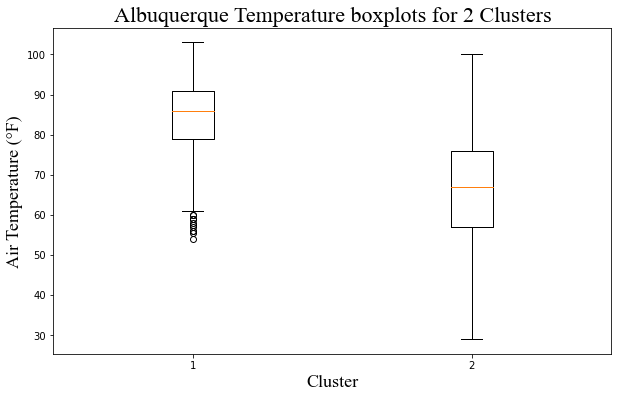

In [25]:
# make a boxplot of temperature for the 4 clusters

tempClusters=[cluster1["drytemp_F"],cluster2["drytemp_F"]] #,cluster3["drytemp_F"],cluster4["drytemp_F"]]

plt.figure(figsize = (10,6))
plt.title("Albuquerque Temperature boxplots for 2 Clusters", font = "Times New Roman", fontsize = 22)
plt.xlabel("Cluster", font = "Times New Roman", fontsize = 18)
plt.ylabel("Air Temperature (\N{DEGREE SIGN}F)", font = "Times New Roman", fontsize = 18)
plt.boxplot(tempClusters)

### Variable Histograms
- implemented for 2 clusters
- available in visualizations.py

**future development:**
- plot multiple variables as subplots (2 x n)
- add standard deviation lines (dashed, black)
- add median line (solid black)
- add mean line (solid green)
- change the color of the bars to a more pleasant color
- change the font to times new roman throughout

(0.0, 300.0)

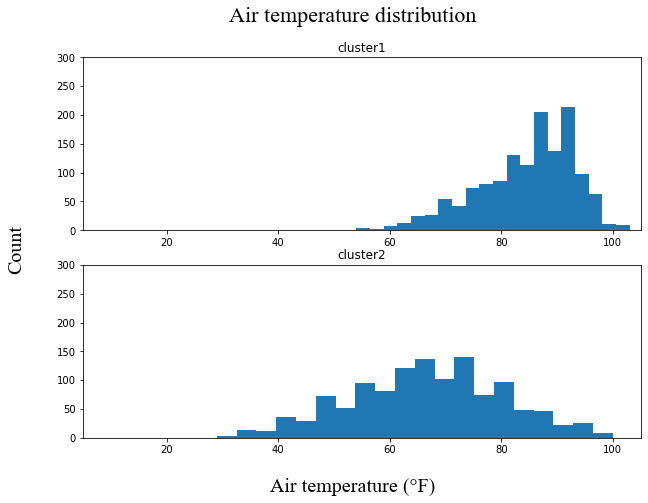

In [26]:
# variable histograms for 4 clusters
fig, ax = plt.subplots(2, figsize = (10,7))
fig.suptitle("Air temperature distribution",font = "Times New Roman", fontsize = 22)
fig.supxlabel("Air temperature (\N{DEGREE SIGN}F)", font = "Times New Roman", fontsize = 20)
fig.supylabel("Count", font = "Times New Roman", fontsize = 20)
ax[0].hist(cluster1["drytemp_F"], bins = 20)
ax[1].hist(cluster2["drytemp_F"], bins = 20)
#ax[1,0].hist(cluster3["drytemp_F"], bins = 20)
#ax[1,1].hist(cluster4["drytemp_F"], bins = 20)
ax[0].set_title("cluster1")
ax[1].set_title("cluster2")
#ax[1,0].set_title("cluster3")
#ax[1,1].set_title("cluster4")

ax[0].set_xlim(5,105)
ax[1].set_xlim(5,105)
#ax[1,0].set_xlim(0,105)
#ax[1,1].set_xlim(0,105)

ax[0].set_ylim(0,300)
ax[1].set_ylim(0,300)
#ax[1,0].set_ylim(0,200)
#ax[1,1].set_ylim(0,200)

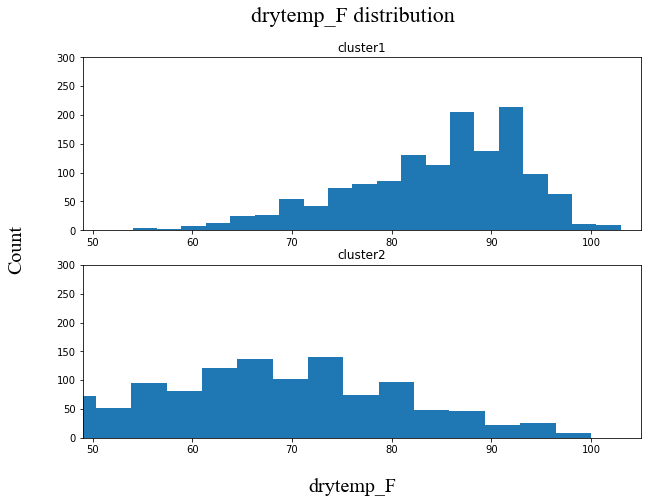

In [27]:
vis.two_cluster_histograms("drytemp_F", cluster2Stats.loc["max"]["drytemp_F"],cluster1Stats.loc["min"]["drytemp_F"], 300, cluster1, cluster2, 20)

### Monthly frequency per cluster
similar to [figure 7](https://journals-ametsoc-org.colorado.idm.oclc.org/view/journals/apme/51/8/jamc-d-11-0227.1.xml)

In [28]:
# add a frequency column for the number of days from each month in each cluster

In [29]:
clusterMonth = pd.DataFrame()
for clusters in range(1,5):
    dayCount = []
    for months in range(1,13):
        dayCount.append(len(albSelect.query("cluster == @clusters and month == @months")))
    clusterMonth[clusters] = dayCount
clusterMonth.index = clusterMonth.index + 1
clusterMonth["month"] = clusterMonth.index

<AxesSubplot:xlabel='month', ylabel='4'>

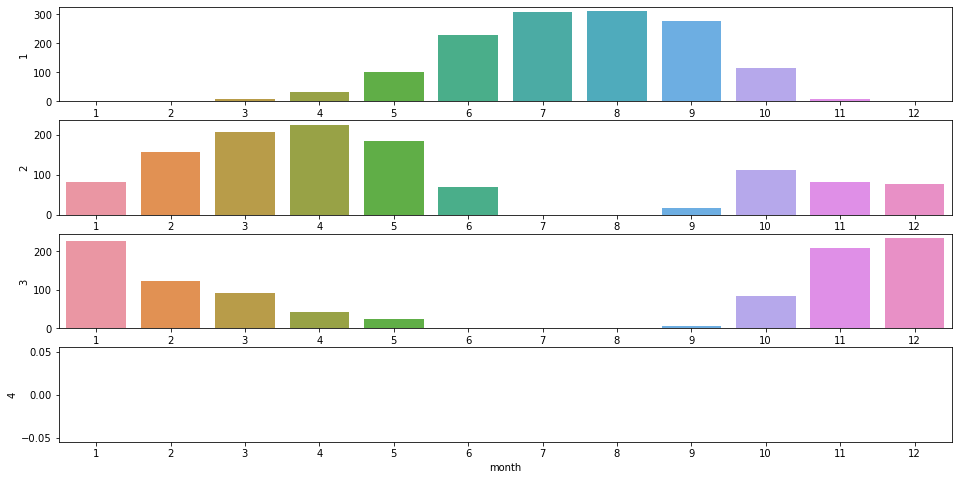

In [30]:
fig, axes = plt.subplots(4, figsize = (16,8))
sb.barplot(x = "month", y = 1, data = clusterMonth, ax = axes[0])
sb.barplot(x = 'month', y = 2, data = clusterMonth, ax = axes[1])
sb.barplot(x = 'month', y = 3, data = clusterMonth, ax = axes[2])
sb.barplot(x = 'month', y = 4, data = clusterMonth, ax = axes[3])